In [18]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from functools import partial


In [19]:
VSA_TYPES = ['FHRR', 'BSC', 'MAP', 'HRR']
DIMENSIONS = [2**i for i in range(6, 13)]
BUNDLE_SIZES = list(range(2, 200, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 10
item_memory_size = 10_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

In [20]:
def norm_hamming_similarity(x, y):
    normalisation_factor = x.shape[1] if x.ndim == 2 else x.shape[0]
    sim = torchhd.hamming_similarity(x, y)
    norm_sim = sim / normalisation_factor
    return norm_sim

def similarity_func_partial(vsa_type, x, y):
    if vsa_type == 'BSC':
        return norm_hamming_similarity(x, y)
    else:
        return torchhd.cosine_similarity(x, y)

In [21]:
sim_tensors = torch.zeros(len(VSA_TYPES), len(DIMENSIONS), item_memory_size) # Store similarities between randomly generated vector and item memory (also randomly generated by definition) for each dimension and vsa type


for vsa_type_idx in tqdm(range(len(VSA_TYPES))):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)


  for dim_idx in tqdm(range(len(DIMENSIONS))):
    dim = DIMENSIONS[dim_idx]

    item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

    reference_vector = torchhd.random(1, dim, vsa=vsa_type, device=device)

    similarities = similarity_func(reference_vector, item_memory)

    sim_tensors[vsa_type_idx, dim_idx, :] = similarities



  0%|          | 0/4 [00:00<?, ?it/s]

vsa type: FHRR


 25%|██▌       | 1/4 [00:00<00:00,  3.72it/s]

vsa type: BSC


100%|██████████| 7/7 [00:00<00:00, 877.00it/s]


vsa type: MAP


100%|██████████| 7/7 [00:00<00:00, 573.34it/s]


vsa type: HRR


100%|██████████| 4/4 [00:00<00:00, 12.93it/s]


### Historgam of similarities for each vsa type

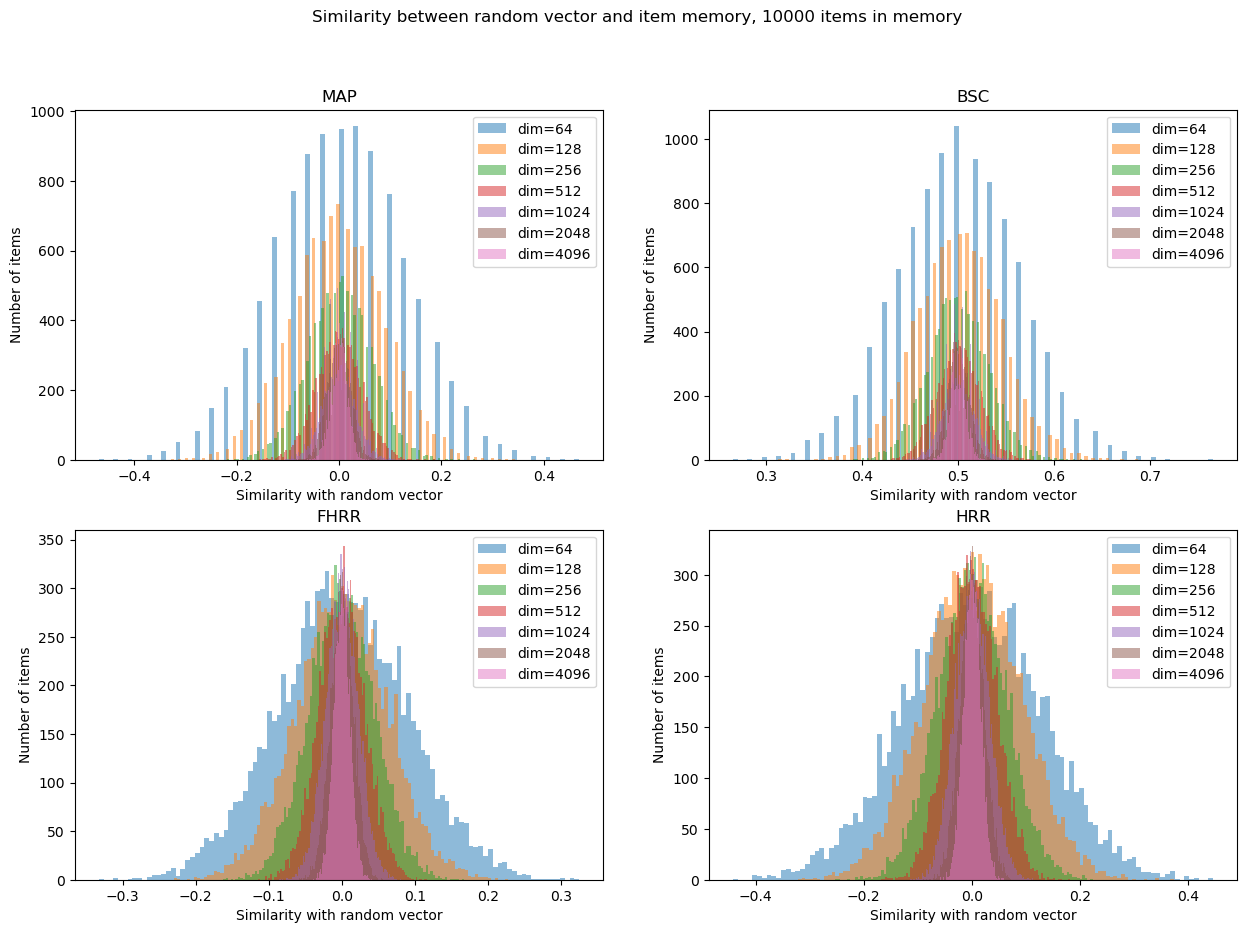

In [22]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity between random vector and item memory, {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].hist(sim_tensors[vsa_type_idx, dim_idx, :].cpu().numpy(), alpha=0.5, label=f'dim={DIMENSIONS[dim_idx]}', bins=item_memory_size//100)

    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('Similarity with random vector')
    ax[row, col].set_ylabel('Number of items')
    ax[row, col].legend()
# fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

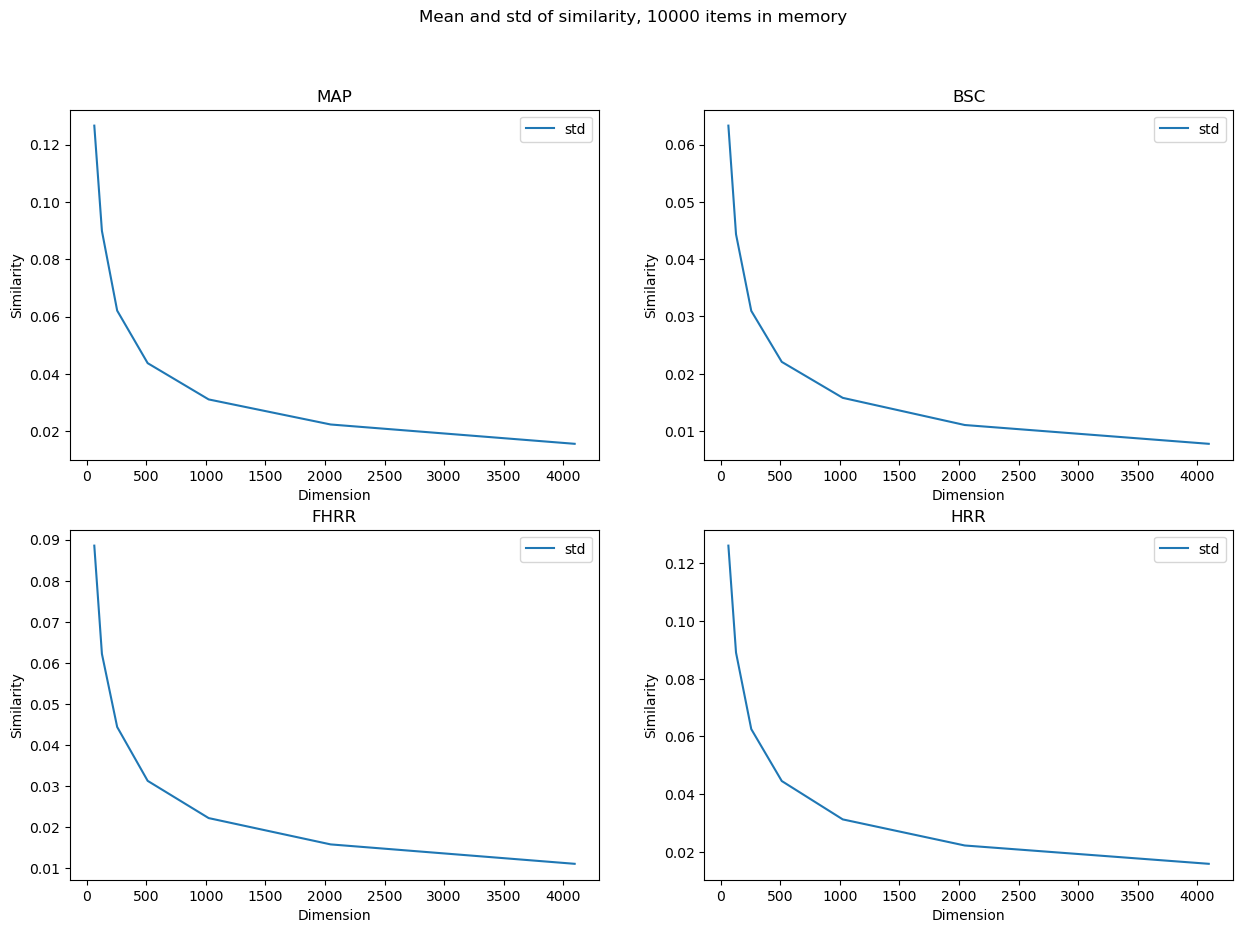

In [23]:
# Plotting mean and std of similarity for each vsa type

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Mean and std of similarity, {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    mean_similarities = torch.mean(sim_tensors[vsa_type_idx, :, :], dim=1)
    std_similarities = torch.std(sim_tensors[vsa_type_idx, :, :], dim=1)
    # ax[row, col].plot(DIMENSIONS, mean_similarities.cpu().numpy(), label='mean')
    ax[row, col].plot(DIMENSIONS, std_similarities.cpu().numpy(), label='std')
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('Dimension')
    ax[row, col].set_ylabel('Similarity')
    ax[row, col].legend()

Why does the normalization have such a big effect on the similarity for BSC and MAP HDVectors?
Normalization intoduces noice, especially for BSC and MAP HDVectors, which have only 2 possible values for each dimension. For MAP I believe a solid workaround is to use MAP-I instead of MAP-B, which is actually the default for torchhd.

In [24]:
vsa_type = 'MAP'


def seq_bundling(vecs):
    bundle_vec = vecs[0]
    for vec in vecs[1:]:
        bundle_vec = bundle_vec.bundle(vec)
        if type(vecs[0]) == torchhd.MAPTensor:
            bundle_vec = bundle_vec.clipping(1)
    return bundle_vec


dim = 10
amount_of_items = 5

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
print(_bundle)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)
print(_multiset)


dim = 500
amount_of_items = 10

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)

sim_func = partial(similarity_func_partial, vsa_type)

_bundle_similarities = [sim_func(k, _bundle) for k in experiment_vecs]
_multiset_similarities = [sim_func(k, _multiset) for k in experiment_vecs]


# effect is exaggerated here by first bundling all identity vectors and then bundling the random vectors
# leading to the fact that the similarity to identity vectors is near 0 when we bundle sequentially
print(f'average similarity of sequential bundling: {torch.mean(torch.stack(_bundle_similarities))}')
print(f'average similarity of multiset: {torch.mean(torch.stack(_multiset_similarities))}')

MAPTensor([ 0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.])
MAPTensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])
average similarity of sequential bundling: MAPTensor(0.1287)
average similarity of multiset: MAPTensor(0.5096)


In [32]:
import torch.nn.functional as F

v = torchhd.random(100, 1000, vsa='HRR')

first = v[0]
print(f"euclidean norm of first vector: {torch.norm(first)}")
first = torchhd.random(1, 1000, vsa='HRR')
seq_bundle_vec = torchhd.random(1, 1000, vsa='HRR')
print(f"cosine similarity of sequential bundle vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")


for i in range(1, 100):
    seq_bundle_vec = seq_bundle_vec.bundle(v[i])
    seq_bundle_vec = F.normalize(seq_bundle_vec, p=2, dim=-1)

print(f"euclidean norm of sequential bundle vector: {torch.norm(seq_bundle_vec)}")
print(f"cosine similarity of sequential bundle vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")
    

euclidean norm of first vector: HRRTensor(1.0096)
cosine similarity of sequential bundle vector and first vector: HRRTensor([[0.0394]])
euclidean norm of sequential bundle vector: HRRTensor(1.0000)
cosine similarity of sequential bundle vector and first vector: HRRTensor([[-0.0332]])
